In [35]:
import pandas as pd
import os
import re
import numpy as np
import json
import codecs
import collections
import matplotlib.pyplot as plt
import sklearn.utils



## Cleaning tasks necessary

cleaning

Lemmatization

Conversion into w2v vectors


In [6]:
ls data/yelp/yelp_training_set

yelp_training_set_business.json  yelp_training_set_review.json
yelp_training_set_checkin.json   yelp_training_set_user.json


In [12]:
with codecs.open("data/yelp/yelp_training_set/yelp_training_set_review.json") as fp:
    datas = []
    for l in fp.readlines():
        datas.append(json.loads(l))
        
    reviews = pd.DataFrame.from_records(datas)

In [13]:
reviews.head()

,business_id,date,review_id,stars,text,type,user_id,votes
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,"{'funny': 0, 'useful': 5, 'cool': 2}"
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,"{'funny': 0, 'useful': 0, 'cool': 0}"
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,"{'funny': 0, 'useful': 1, 'cool': 0}"
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,"{'funny': 0, 'useful': 2, 'cool': 1}"
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,"{'funny': 0, 'useful': 0, 'cool': 0}"


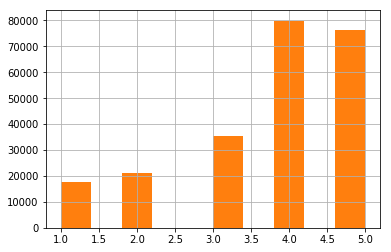

In [23]:
reviews.stars.hist()
plt.show()

In [14]:
with codecs.open("data/yelp/yelp_training_set/yelp_training_set_business.json") as fp:
    datas = []
    for l in fp.readlines():
        datas.append(json.loads(l))
        
    biz = pd.DataFrame.from_records(datas)
    
biz.head()
        

,business_id,categories,city,full_address,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,rncjoVoEFUJGCUoC1JgnUA,"[Accountants, Professional Services, Tax Servi...",Peoria,"8466 W Peoria Ave\nSte 6\nPeoria, AZ 85345",33.581867,-112.241596,Peoria Income Tax Service,[],True,3,5.0,AZ,business
1,0FNFSzCFP_rGUoJx8W7tJg,"[Sporting Goods, Bikes, Shopping]",Phoenix,"2149 W Wood Dr\nPhoenix, AZ 85029",33.604054,-112.105933,Bike Doctor,[],True,5,5.0,AZ,business
2,3f_lyB6vFK48ukH6ScvLHg,[],Phoenix,"1134 N Central Ave\nPhoenix, AZ 85004",33.460526,-112.073933,Valley Permaculture Alliance,[],True,4,5.0,AZ,business
3,usAsSV36QmUej8--yvN-dg,"[Food, Grocery]",Phoenix,"845 W Southern Ave\nPhoenix, AZ 85041",33.392210,-112.085377,Food City,[],True,5,3.5,AZ,business
4,PzOqRohWw7F7YEPBz6AubA,"[Food, Bagels, Delis, Restaurants]",Glendale Az,"6520 W Happy Valley Rd\nSte 101\nGlendale Az, ...",33.712797,-112.200264,Hot Bagels & Deli,[],True,14,3.5,AZ,business


In [27]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


import gensim
model = gensim.models.KeyedVectors.load_word2vec_format("w2v/GoogleNews-vectors-negative300.bin", binary=True)


data_files = [f for f in os.listdir("data") if f.endswith(".json")]

NUM_WORDS = 200000
maxSeqLength = 50
NEGATIVE_REVIEW_MAX = 2
POSITIVE_REVIEW_MIN = 4

def review_sentiment(score):
    if score <= NEGATIVE_REVIEW_MAX:
        return 0
    elif score >= POSITIVE_REVIEW_MIN:
        return 1
    return -1

def clean_review_text(rev):
    """
        Lemmatize and lowercase everything, also remove punctuation
    """
    rev = rev.lower()
    tokens = rev.split()
    lemmatized_tokens = []
    for t in tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(t.strip(".,!'")))
        
    return ' '.join(lemmatized_tokens)


def is_valid_word(w):
    """
        Only want lower case words that aren't stopwords and arent tags or other nonsense like ####
    """
    if not w.lower() == w:
        return False
#     if w in stop_words:
#         return False
    if re.search("[^(\w|\'|\-)]", w):
        return False
#     if not w in model.wv.vocab:
#         # shouldnt have to add this but for some reason it makes a difference, where are these words coming from?
#         return False
    
    return True
     

In [20]:

vocab_counts = [(word, vocab_obj.count) for  (word, vocab_obj) in model.vocab.items() if is_valid_word(word)]
vocab_counts = sorted(vocab_counts, key=lambda x:x[1], reverse=True)
print("found counts")
# needs a list for ordering
final_vocab = [v[0] for v in vocab_counts[0:NUM_WORDS]]
print("vocab set")
# get a lookup for O[1] access
final_vocab_lookup = {v:final_vocab.index(v) for v in final_vocab}



found counts
vocab set


In [40]:
#### review_sizes = collections.defaultdict(int)


def review_to_w2v_vector(rev):
    split_words = rev.split()
    
    words_in_order = np.random.randint(len(final_vocab), size=maxSeqLength, dtype='int32')
    indexCounter = 0
    good_words = [w for w in split_words if w in final_vocab_lookup]
    review_sizes[len(good_words)] += 1
    
    for word in good_words:
        words_in_order[indexCounter] = final_vocab_lookup[word]
        indexCounter += 1
        if indexCounter >= maxSeqLength:
            break
    return words_in_order
i=0

file_name = "w2vreviews_" + str(i)
label_file_name = "w2vlabels_" + str(i)
batch = reviews
SPLIT_SIZE = 16384

print("batch selected",i, batch.shape)
batch = sklearn.utils.shuffle(batch, random_state=1)
print("shape", batch.shape)
batch = batch[0:SPLIT_SIZE]
batch["clean_text"] = batch.text.map(clean_review_text)


batch selected 0 (229907, 10)


In [43]:

def one_hot_label(label):
    if label==0:
        return np.array([1,0])
    else:
        return np.array([0,1])

In [44]:
vecs = batch.clean_text.map(review_to_w2v_vector)
batch["sentiment"] = batch.stars.map(review_sentiment)
print("mean sentiment", batch.sentiment.mean())
arr = np.zeros((batch.shape[0], maxSeqLength))
labels = np.zeros((batch.shape[0], 2))



for j, v in enumerate(vecs):
    arr[j,] = v
    labels[j,] = one_hot_label(batch.sentiment.iloc[j])


print("saving arr", arr.shape)
np.save("data/yelp/" + file_name, arr)
np.save("data/yelp/" + label_file_name, labels)

mean sentiment 0.521362304688
saving arr (16384, 50)
